# Project 2: Helping realtors to predict sale prices in Ames 

Done by: Richelle-Joy Chia, data scientist and realtor at MyProperty


Problem statement: How can we help realtors effectively and efficiently predict the market value of houses in Ames, Iowa?

## Part 4: Modeling and insights

In [1]:
# import relevant libraries 

import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import combinations
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from math import sqrt # alternative to (variable)**0.5
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(style="white", color_codes=True)
colors_palette = sns.color_palette("GnBu_d")
sns.set_palette(colors_palette)


In [2]:
# import datasets

train_data = pd.read_csv('./datasets/train_data_final.csv')
test_data = pd.read_csv('./datasets/test_data_final.csv')
test_ids = pd.read_csv('./datasets/test_data_final.csv')['Id']

## Model Preparation

### Train/test split

- This step is used to estimate the performance of a prediction-based algorithim. This will allow me to compare my machine learning model results to the machine results. 

In [3]:
features = [col for col in train_data._get_numeric_data().columns if col !='SalePrice']
features
X = train_data[features]
y = train_data['SalePrice']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling

- This step is crucial for the model as there are some features that may have different properties or do not follow a standard normal distribution. In other words, standardizing the features would help put everything on the same page.

In [5]:
ss = StandardScaler()
ss.fit(X_train)

X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

### Instantiate our models 

In [6]:
lr = LinearRegression()

In [7]:
ridge = RidgeCV(alphas=np.linspace(1, 200, 100))

In [8]:
lasso = LassoCV(n_alphas=100)

In [9]:
enet_alphas = np.arange(0.5, 1.0, 0.005)
enet_ratio = 0.5
enet = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)

### Cross Validation

- Estimating the skill of a machine learning model on unseen data to validate the performance of our model.

In [10]:
# linear regression 

lr_cv_scores = cross_val_score(lr,X_train_sc,y_train,cv=5)
print('R2:', lr_cv_scores.mean())

lr_cv_mse_scores = -cross_val_score(lr,X_train_sc,y_train,cv=5, scoring ='neg_mean_squared_error')
print('RSME:', np.sqrt(lr_cv_mse_scores.mean()))


R2: 0.8077673415049886
RSME: 34373.60518751956


In [11]:
# ridge regression model 

ridge_cv_scores = cross_val_score(ridge,X_train_sc,y_train,cv=5)
print('R2:', ridge_cv_scores.mean())
ridge_cv_mse_scores = -cross_val_score(ridge,X_train_sc,y_train,cv=5, scoring ='neg_mean_squared_error')
print('RSME:', np.sqrt(ridge_cv_mse_scores.mean()))

R2: 0.8174731251240397
RSME: 33604.00704243355


In [12]:
# lasso regression

lasso_cv_scores = cross_val_score(lasso,X_train_sc,y_train,cv=5)
print('R2:', lasso_cv_scores.mean())
lasso_cv_mse_scores = -cross_val_score(lasso,X_train_sc,y_train,cv=5, scoring ='neg_mean_squared_error')
print('RSME:', np.sqrt(lasso_cv_mse_scores.mean()))

R2: 0.8134579622935604
RSME: 33850.43735313373


In [13]:
# elasticnet regression model

enet_cv_scores = cross_val_score(enet,X_train_sc,y_train,cv=5)
print('R2:', enet_cv_scores.mean())
enet_cv_mse_scores = -cross_val_score(enet,X_train_sc,y_train,cv=5, scoring ='neg_mean_squared_error')
print('RSME:', np.sqrt(enet_cv_mse_scores.mean()))

R2: 0.8176535124242397
RSME: 33634.31877909039


Based on the $R^2$ scoring confirmation from our training cross validation, RidgeCV seems to be doing the best (RSME = 33604.00). However, since the difference is not too far off, we will explore all four models.

## Model Fitting and Evaluation

### Linear regression

In [14]:
# fit lr instantiated model 

lr.fit(X_train_sc,y_train)

# check the R^2 on the training and testing sets, and the cv score from above
print("Training R2(LR): " + str(lr.score(X_train_sc,y_train)))
print("Testing R2(LR): " + str(lr.score(X_test_sc,y_test)))
print("Estimate of Testing R2(LR): " + str(lr_cv_scores.mean()))

Training R2(LR): 0.8664148730543457
Testing R2(LR): 0.8876323676751031
Estimate of Testing R2(LR): 0.8077673415049886


In [15]:
# check the MSE on the training and testing sets

print("Training RMSE(LR): " + str(np.sqrt(mean_squared_error(y_train, lr.predict(X_train_sc)))))
print("Testing RMSE(LR): " + str(np.sqrt(mean_squared_error(y_test,lr.predict(X_test_sc)))))
print("Estimate of Testing RMSE(LR): " + str(np.sqrt(lr_cv_mse_scores.mean())))

Training RMSE(LR): 29155.04429797437
Testing RMSE(LR): 25838.615064808415
Estimate of Testing RMSE(LR): 34373.60518751956


Based on the RMSE, it seems that our model is performing worst on the testing set than on the training set, suggesting that there may be some overfitting in the model. 


### Ridge regression

In [16]:
# fit RidgeCV model to data

ridge.fit(X_train_sc,y_train);

In [17]:
# instantiate and passing alpha = 10

best_ridge_alpha = Ridge(alpha=10)
best_ridge_alpha

Ridge(alpha=10)

In [18]:
# create new ridge model with optimal alpha and fit to training data
ridge = Ridge(alpha=10)
ridge.fit(X_train_sc,y_train);

In [19]:
# check the R^2 on the training and testing sets, and the cv score from above

print("Training R2(ridge) " + str(ridge.score(X_train_sc,y_train)))
print("Testing R2(ridge) " + str(ridge.score(X_test_sc,y_test)))
print("Estimate of Testing R2(ridge) " + str(ridge_cv_scores.mean()))

Training R2(ridge) 0.8663411246770953
Testing R2(ridge) 0.8875788445873051
Estimate of Testing R2(ridge) 0.8174731251240397


In [20]:
# check the MSE on the training and testing sets

print("Training MSE(Ridge) ", np.sqrt(mean_squared_error(y_train, ridge.predict(X_train_sc))))
print("Testing MSE(Ridge) ", np.sqrt(mean_squared_error(y_test,ridge.predict(X_test_sc))))
print("Estimate of Testing RMSE (Ridge) " + str(np.sqrt(ridge_cv_mse_scores.mean())))


Training MSE(Ridge)  29163.091004145837
Testing MSE(Ridge)  25844.768072528255
Estimate of Testing RMSE (Ridge) 33604.00704243355


Our model is still overfitting, but ridge regression seems to return better results than our standard linear regression model.

### Lasso regression

In [21]:
# fit LassoCV model to data

lasso.fit(X_train_sc,y_train)

LassoCV()

In [22]:
# generate best alpha

best_lasso_alpha = lasso.alpha_
best_lasso_alpha

517.5128476844834

In [23]:
# Create new lasso model with optimal alpha and fit to training data

lasso = Lasso(alpha=best_lasso_alpha)
lasso.fit(X_train_sc, y_train)

Lasso(alpha=517.5128476844834)

In [24]:
# check the R^2 on the training and testing sets, and the cv score from above

print("Training R2(Lasso) ", lasso.score(X_train_sc,y_train))
print("Testing R2(Lasso):", lasso.score(X_test_sc,y_test))
print("Estimate of Testing R2(Lasso):", lasso_cv_scores.mean())

Training R2(Lasso)  0.861684651723077
Testing R2(Lasso): 0.8864201370193251
Estimate of Testing R2(Lasso): 0.8134579622935604


In [25]:
# check the MSE on the training and testing sets

print("Training RMSE(Lasso):", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train_sc))))
print("Testing RMSE(Lasso):", np.sqrt(mean_squared_error(y_test, lasso.predict(X_test_sc))))
print("Estimate of Testing RMSE(Lasso):", np.sqrt(lasso_cv_mse_scores.mean()))

Training RMSE(Lasso): 29666.740937477392
Testing RMSE(Lasso): 25977.61566600731
Estimate of Testing RMSE(Lasso): 33850.43735313373


Similar to the two models above, our model here is still overfitting slightly. 

### ElasticNet Regression

In [26]:
# set up a list of alphas to check

enet_alphas = np.arange(0.01, 1.0, 0.005)
enet_ratio = 0.5

# instantiate model
enet = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5, max_iter=5_000)

# fit model using optimal alphas
enet = enet.fit(X_train_sc, y_train)

In [27]:
# here is the optimal value of alpha
enet_optimal_alpha = enet.alpha_
enet_optimal_alpha

0.36499999999999994

In [28]:
# Create new enet model with optimal alpha and fit to training data

enet = ElasticNet(alpha=enet_optimal_alpha)
enet.fit(X_train_sc, y_train)

ElasticNet(alpha=0.36499999999999994)

In [29]:
# new cross val scores 

enet_cv_scores = cross_val_score(enet,X_train_sc,y_train,cv=5)
enet_cv_scores.mean()

0.8177446128162662

In [30]:
enet_cv_mse_scores = -cross_val_score(enet,X_train_sc,y_train,cv=5, scoring ='neg_mean_squared_error')
np.sqrt(enet_cv_mse_scores.mean())

33594.58652385908

In [31]:
# check the R^2 on the training and testing sets, and the cv score from above

print('Training R2(ElasticNet):', enet.score(X_train_sc,y_train))
print('Testing R2(ElasticNet):', enet.score(X_test_sc,y_test))
print('Estimate of Testing R2(ElasticNet): ', enet_cv_scores.mean())

Training R2(ElasticNet): 0.8586260734894001
Testing R2(ElasticNet): 0.8825358334082505
Estimate of Testing R2(ElasticNet):  0.8177446128162662


In [32]:
# check the MSE on the training and testing sets

print('Training MSE(ElasticNet):', np.sqrt(mean_squared_error(y_train, enet.predict(X_train_sc))))
print('Testing MSE(ElasticNet):', np.sqrt(mean_squared_error(y_test, enet.predict(X_test_sc))))
print('Estimate of Testing RMSE(ElasticNet):', np.sqrt(enet_cv_mse_scores.mean()))

Training MSE(ElasticNet): 29992.95887191554
Testing MSE(ElasticNet): 26418.084067147363
Estimate of Testing RMSE(ElasticNet): 33594.58652385908


We see that our model is still overfitting, but the ElasticNet regression model seems to return the best results among all 4 models. 

## Time to explore hyperparameter tuning 
### Grid search with ElasticNet

In [33]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "l1_ratio": np.linspace(0.01,1,30),
    "alpha": np.logspace(.01, 10, 40)}
en = ElasticNet()
en_gscv = GridSearchCV(en, param_grid=param_grid, verbose=1, cv=5, n_jobs=-1)

In [34]:
# fit the GridSearchCV object to our data

resid_predict = en_gscv.fit(X_train_sc, y_train).predict(X_train_sc)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


In [35]:
# print out the set of hyperparameters that achieved the best score.

en_gscv.best_params_

{'alpha': 6.004288319960373, 'l1_ratio': 0.9658620689655173}

In [36]:
en_gscv.score(X_train_sc, y_train)


0.8575172525373447

Using hyperparameter tuning, we see that the new renovatable features explain approximately 85% of the residuals of the fixed model. Moreover, the L1 ratio of this Elasitcnet is 1, which represents Lasso regression.

In [37]:
en_gscv.cv_results_

{'mean_fit_time': array([0.00530157, 0.00634933, 0.00502806, ..., 0.00092664, 0.00088925,
        0.00077019]),
 'std_fit_time': array([0.00154274, 0.00329098, 0.00138754, ..., 0.00010834, 0.00011759,
        0.00026762]),
 'mean_score_time': array([0.00033946, 0.0004087 , 0.00047231, ..., 0.00019569, 0.00018892,
        0.00015135]),
 'std_score_time': array([4.88255172e-05, 1.55204115e-04, 4.36166548e-04, ...,
        2.33520744e-05, 3.53755972e-05, 4.77812247e-05]),
 'param_alpha': masked_array(data=[1.023292992280754, 1.023292992280754,
                    1.023292992280754, ..., 10000000000.0, 10000000000.0,
                    10000000000.0],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_l1_ratio': masked_array(data=[0.01, 0.04413793103448276, 0.07827586206896552, ...,
                    0.9317241379310346, 0.9658620689655173, 1.0],
              mask=[False, False, False, ..., False, False, False]

### Searching for the best hyperparameters

- Here, I decided to use GridSearch with ElasticNet as it was the regression model that produced the best results.

In [38]:
param_grid = {
    "l1_ratio": np.linspace(0.01,1,30),
    "alpha": np.logspace(.01, 10, 40)}
en = ElasticNet()
en_gscv = GridSearchCV(en, param_grid=param_grid, verbose=1, cv=5, n_jobs=-1)

In [39]:
resid_predict = en_gscv.fit(X_train, y_train).predict(X_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


In [40]:
en_gscv.best_params_

{'alpha': 6.004288319960373, 'l1_ratio': 1.0}

In [41]:
en_gscv.score(X_train, y_train)

0.8663653532431944

- From this, we can see a slight increase in scores. Furthermore, it seems like the L1 ratio of this ElasticNet is 1, suggesting that it is a Lasso regression. Hence, in the final model below, I will be using Lasso regression, which will also help to zero out some of the features.

#### Summary of the train-test scores and RMSE 

| Model      | Train score | Test score | Train RMSE | Test RMSE |
|------------|-------------|------------|------------|-----------|
| LR         | .866        | .808       | 29155.044  | 34373.605 |
| Ridge      | .866        | .817       | 29163.091  | 33604.007 |
| Lasso      | .861        | .813       | 29666.741  | 33850.437 |
| ElasticNet | .859        | .818       | 29992.959  | 33594.587 |

After making the respective submissions on Kaggle, turns out our ElasticNet model returned with the best score in predicting house prices as well. However, like the table above, the scores did not differ significantly from other models. 

Since the scores do not differ too much from each other, I decided to use Lasso regression as the final model as it does help to cut down on the features, further reducing any potential noise. The  RMSE score on Kaggle is 24978.04.

### Fitting model on entire training dataset

In [42]:
# Refit model on entire training dataset
X_scaled = ss.fit_transform(X)
lasso = LassoCV()
lasso.fit(X_scaled, y)
lasso.score(X_scaled,y)

0.8642166284098514

In [43]:
# Remaining features after zeroing by lasso regression
print('Total Features before Lasso regression:', len(features))
print('Features Zeroed by Lasso regression:', len(lasso.coef_[lasso.coef_ == 0]))
print('Features Remaining after Lasso regression:', len(features) - len(lasso.coef_[lasso.coef_ == 0]))

Total Features before Lasso regression: 85
Features Zeroed by Lasso regression: 35
Features Remaining after Lasso regression: 50


In [44]:
final_test_scaled = ss.transform(test_data)

In [45]:
final_predictions = lasso.predict(final_test_scaled)

In [46]:
test_data['SalePrice'] = final_predictions

In [47]:
test_data['Id'] = test_ids

In [48]:
# Create csv for submission
submission = test_data[['Id','SalePrice']]
submission.to_csv('./datasets/lasso_ksubmission.csv', index=True)

#View submission
submission.head()

,Id,SalePrice
0,2658,136752.594072
1,2718,168332.693236
2,2414,218399.571508
3,1989,102948.182203
4,625,199475.758802


## Conclusion and Recommendations

To conclude, I used the Lasso regression model as the final model to provide a more efficient and accurate service for realtors to predict the future sale prices of houses in Ames, Iowa. 
- In this model, 85 features were included in the model and 35 features were zeroed out by Lasso regression, which leaves a total of 50 features.

Here is the list of main features that were included: 
- Lot Frontage, Lot Area, Overall Cond, Year Remod/Add, Mas Vnr Area, Exter Cond, Bsmt Qual, Bsmt Exposure, BsmtFin SF 1, BsmtFin SF 2, Bsmt Unf SF, Low Qual Fin SF, Gr Liv Area, Bedroom AbvGr, Kitchen AbvGr, Fireplace Qu, Garage Finish, Garage Area, Wood Deck SF, Open Porch SF, Enclosed Porch, 3Ssn Porch, Screen Porch, Pool Area, Misc Val, Mo Sold, TotalBathroom, isNew, Exterior 1st, Exterior 2nd, Foundation, MS SubClass, Neighborhood. 
    
According to the barplot below, the sqfeet of above grade (ground) living area (Gr Liv Area), selected neighborhoods (Neighborhood_NridgHt and Neighborhood_StoneBr), height of basement (Bsmt Qual), and the size of the garage (Garage Area) are the top few housing features that could predict higher sale prices. 

Moreover, I tried to include these 30 features into the main model, but the RMSE scores did not change significantly (refer to Appendix below for model scores). As such, the final model used is still the Lasso regression model. 

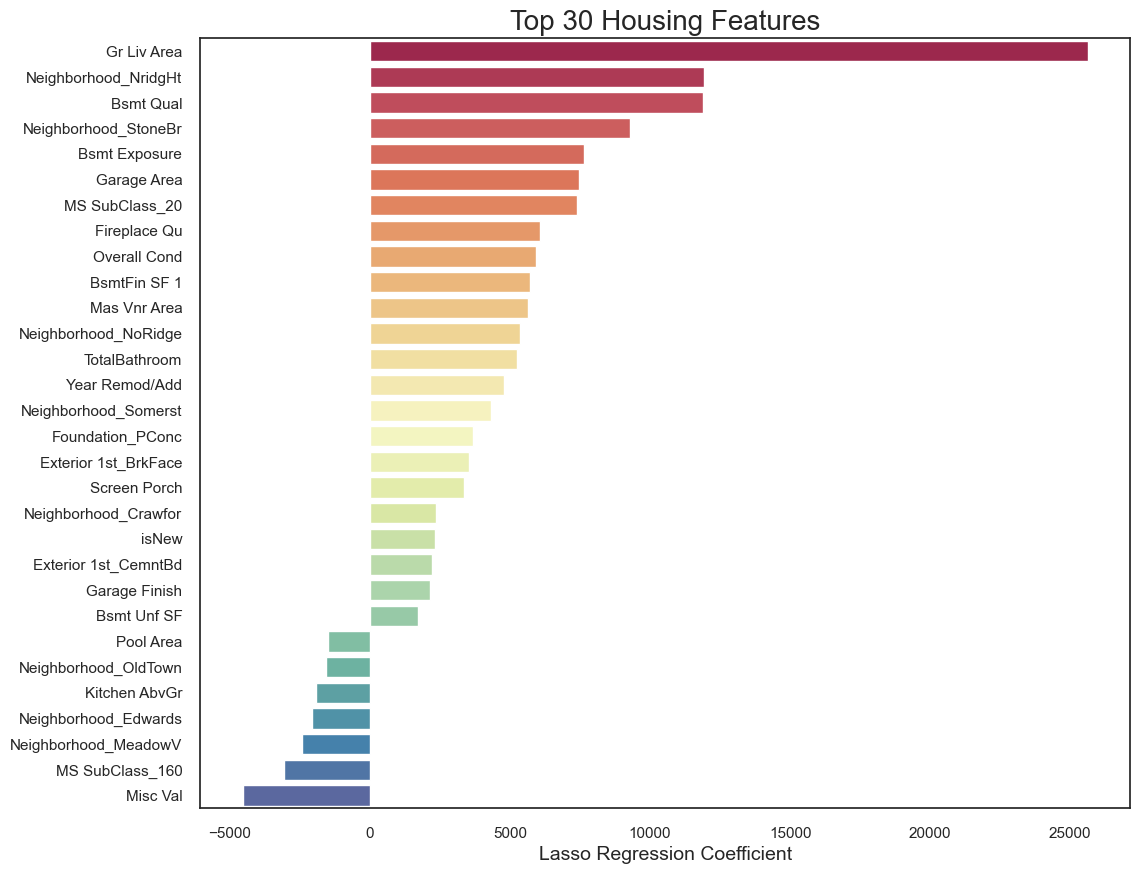

In [49]:
# Create dataframe of features, coefficients and absolute coefficients
lasso_df = pd.DataFrame(columns=['Feature', 'Coef', 'Abs Coef'])
lasso_df['Abs Coef'] = abs(lasso.coef_)
lasso_df['Coef'] = lasso.coef_
lasso_df['Feature'] = features

# Plot top 30 features (sorted by absolute regression coefficient)
plt.figure(figsize=(12,10))
data = lasso_df.sort_values(by='Abs Coef', ascending=False).head(30)[['Feature', 'Coef']] \
               .sort_values(by='Coef', ascending=False).reset_index(drop=True)
    
ax = sns.barplot(data=data, y='Feature', x='Coef', orient='h', palette='Spectral')
ax.set_ylabel('')
ax.set_yticklabels(data['Feature'], size=11)
ax.set_xlabel('Lasso Regression Coefficient', fontsize=14)
plt.title('Top 30 Housing Features', fontsize=20);

## Recommendations

This model will help realtors make better recommendations to others. For example, sellers will be able to know which features to highlight when thinking about selling their house. Realtors will be able to create better proposals that allow them to sell property at current pricings and not undersell their property. Similarly, realtors can help prevent buyers from overpaying and perhaps look for better deals. 

More specifically, I would also recommend realtors to ask their clients to do invest in houses that have a higher above grade living area, be in a better neighborhood (specifically North Ridge or Stone Bridge), have a basement with higher ceilings, or bigger garage area. If the clients are buyers, they should also think about these features before buying so it can help them to earn more profits if they were to sell in the future. 

## Limitations and Future Considerations

These are the limitations and possible solutions related to the dataset:

- Data was collected between 2006-2010, which is more than a decade old. To build an even more accurate model, it would be better to gather new data so as to create a more effective model. This would take into account inflation over the past decade.

- The current model can only be applied to houses in Ames, Iowa, and not be generalized to other cities or states in the US. Perhaps collecting data from neighboring cities would be useful to see if the results hold.

These are the limitations and possible solutions related to the model: 

- The usage of other methods to eliminate features. Perhaps future work could examine other approaches that can also reduce dimentionality (e.g., principal compoenent analysis). 

- One of the cons of the current model is that it included outliers. I did attempt to exclude outliers from the model, but it did not increase the scores significantly. However, after collecting more data, it would be good to re-examine if outliers would influence the model. 

## Appendix
- The section below shows that when I use the top 30 features, the scores do not improve significantly. I used the ElasticNet regression model to examine the scores.

In [50]:
# choosing top 30 features based on enet regerssion coefficient 
new_train_data = train_data[['Gr Liv Area', 'Neighborhood_NridgHt', 'Bsmt Qual', 'Neighborhood_StoneBr', 'Garage Area', 'TotalBathroom', 'BsmtFin SF 1', 'Fireplace Qu', 'Mas Vnr Area', 'Bsmt Exposure', 'Neighborhood_NoRidge', 'Overall Cond', 'Year Remod/Add', 'Screen Porch', 'MS SubClass_20', 'Bsmt Unf SF', 'Foundation_PConc', 'Garage Finish', 'Exterior 1st_CemntBd', 'Lot Area', 'Exterior 1st_BrkFace', 'isNew', 'Neighborhood_Gilbert', 'MS SubClass_120', 'Neighborhood_OldTown', 'Neighborhood_NAmes', 'Neighborhood_MeadowV', 'MS SubClass_160', 'Neighborhood_Edwards', 'Misc Val', 'SalePrice']]
new_test_data = test_data[['Gr Liv Area', 'Neighborhood_NridgHt', 'Bsmt Qual', 'Neighborhood_StoneBr', 'Garage Area', 'TotalBathroom', 'BsmtFin SF 1', 'Fireplace Qu', 'Mas Vnr Area', 'Bsmt Exposure', 'Neighborhood_NoRidge', 'Overall Cond', 'Year Remod/Add', 'Screen Porch', 'MS SubClass_20', 'Bsmt Unf SF', 'Foundation_PConc', 'Garage Finish', 'Exterior 1st_CemntBd', 'Lot Area', 'Exterior 1st_BrkFace', 'isNew', 'Neighborhood_Gilbert', 'MS SubClass_120', 'Neighborhood_OldTown', 'Neighborhood_NAmes', 'Neighborhood_MeadowV', 'MS SubClass_160', 'Neighborhood_Edwards', 'Misc Val']]
                             
                                             

In [51]:
features = [col for col in new_train_data._get_numeric_data().columns if col !='SalePrice']
features
X_1 = new_train_data[features]
y_1 = new_train_data['SalePrice']

In [52]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [53]:
ss = StandardScaler()
ss.fit(X_train_1)

X_train_sc1 = ss.transform(X_train_1)
X_test_sc1 = ss.transform(X_test_1)

In [54]:
# set up a list of alphas to check

enet_alphas = np.arange(0.01, 1.0, 0.005)
enet_ratio = 0.5

# instantiate model
enet = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5, max_iter=5_000)

# fit model using optimal alphas
enet = enet.fit(X_train_sc1, y_train_1)

In [55]:
# here is the optimal value of alpha
enet_optimal_alpha_1 = enet.alpha_
enet_optimal_alpha_1

0.31499999999999995

In [56]:
# Create new enet model with optimal alpha and fit to training data

enet1 = ElasticNet(alpha=enet_optimal_alpha_1)
enet1.fit(X_train_sc1, y_train_1)

ElasticNet(alpha=0.31499999999999995)

In [57]:
# new cross val scores 

enet_cv_scores1 = cross_val_score(enet1,X_train_sc1,y_train_1,cv=5)
enet_cv_scores1.mean()

0.8201331074263749

In [58]:
enet_cv_mse_scores1 = -cross_val_score(enet1,X_train_sc1,y_train_1,cv=5, scoring ='neg_mean_squared_error')
np.sqrt(enet_cv_mse_scores1.mean())

33383.235939774415

In [59]:
# check the R^2 on the training and testing sets, and the cv score from above

print('Training R2(ElasticNet):', enet1.score(X_train_sc1,y_train_1))
print('Testing R2(ElasticNet):', enet1.score(X_test_sc1,y_test_1))
print('Estimate of Testing R2(ElasticNet): ', enet_cv_scores1.mean())

Training R2(ElasticNet): 0.847316401846411
Testing R2(ElasticNet): 0.8809485442564251
Estimate of Testing R2(ElasticNet):  0.8201331074263749


In [60]:
# check the MSE on the training and testing sets

print('Training MSE(ElasticNet):', np.sqrt(mean_squared_error(y_train_1, enet.predict(X_train_sc1))))
print('Testing MSE(ElasticNet):', np.sqrt(mean_squared_error(y_test_1, enet.predict(X_test_sc1))))
print('Estimate of Testing RMSE(ElasticNet):', np.sqrt(enet_cv_mse_scores1.mean()))

Training MSE(ElasticNet): 31169.572430993885
Testing MSE(ElasticNet): 26595.978434110682
Estimate of Testing RMSE(ElasticNet): 33383.235939774415
